In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import newton
import math
import yfinance as yf
from scipy.optimize import fsolve

In [2]:
#read the excel file 
df = pd.read_excel('data_sidd.xlsx')

In [3]:
#download NIFTY 50 data 
#change date according to your requirement
nifty = yf.download('^NSEI',start='2019-01-01',end='2019-12-31')
nifty.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,10868.849609,10895.349609,10735.049805,10792.500000,10792.500000,309700
2019-01-03,10796.799805,10814.049805,10661.250000,10672.250000,10672.250000,286200
2019-01-04,10699.700195,10741.049805,10628.650391,10727.349609,10727.349609,296600
2019-01-07,10804.849609,10835.950195,10750.150391,10771.799805,10771.799805,269400
2019-01-08,10786.250000,10818.450195,10733.250000,10802.150391,10802.150391,277700


In [4]:
nifty['Daily_Return'] = nifty['Adj Close'].pct_change()
data = nifty.dropna()
sigma = np.std(nifty['Daily_Return']) * np.sqrt(252)

#print the sigma value
print(sigma)


0.1392989305626747


In [5]:
df.head()

,Symbol,Date,Expiry,Optiontype,StrikePrice,Open,High,Low,Close,LTP,SettlePrice,Noofcontracts,TurnoverinLakhs,PremiumTurnoverinLakhs,OpeInt,ChangeinOI,UnderlyingValue
0,NIFTY,2020-01-24,2020-04-01,PE,10700,-,-,-,1.45,-,0.90,-,-,-,-,-,12248.25
1,NIFTY,2020-01-24,2020-04-01,PE,10750,-,-,-,1.85,-,1.15,-,-,-,-,-,12248.25
2,NIFTY,2020-01-24,2020-04-01,PE,10800,-,-,-,2.40,-,1.45,-,-,-,-,-,12248.25
3,NIFTY,2020-01-24,2020-04-01,PE,10850,-,-,-,3.00,-,1.90,-,-,-,-,-,12248.25
4,NIFTY,2020-01-24,2020-04-01,PE,10900,-,-,-,3.80,-,2.40,-,-,-,-,-,12248.25


In [6]:
def black_scholes_option_price(option_type, S, K, T, r, sigma):
    """
    Calculate the Black-Scholes option price.
    
    Parameters:
    - option_type: 'call' or 'put'
    - S: current stock price
    - K: option strike price
    - T: time to expiration (in years)
    - r: risk-free interest rate
    - sigma: volatility of the underlying stock
    
    Returns:
    - Option price
    """
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'CE':
        option_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'PE':
        option_price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return option_price

In [7]:
def implied_volatility(option_type, market_price, S, K, T, r, initial_volatility=sigma, tolerance=1e-6, max_iter=1000):
    """
    Calculate implied volatility using the Newton-Raphson method.
    
    Parameters:
    - option_type: 'call' or 'put'
    - market_price: observed market price of the option
    - S: current stock price
    - K: option strike price
    - T: time to expiration (in years)
    - r: risk-free interest rate
    - initial_volatility: initial guess for volatility
    - tolerance: desired level of accuracy
    - max_iter: maximum number of iterations
    
    Returns:
    - Implied volatility
    """
    def objective_function(sigma):
        return black_scholes_option_price(option_type, S, K, T, r, sigma) - market_price

    implied_vol = fsolve(objective_function, initial_volatility)#, tol=tolerance, maxiter=max_iter)
    return implied_vol


In [8]:
# Example usage:
option_type = 'call'
market_price = 10.0
S = 100.0
K = 100.0
T = 1.0
r = 0.05


In [9]:
# implied_vol = implied_volatility(option_type, market_price, S, K, T, r)
# print(f"Implied Volatility: {implied_vol:.4f}")

In [10]:
#get info for dataframe 
df.info()

print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Symbol                  8700 non-null   object        
 1   Date                    8700 non-null   datetime64[ns]
 2   Expiry                  8700 non-null   datetime64[ns]
 3   Optiontype              8700 non-null   object        
 4   StrikePrice             8700 non-null   int64         
 5   Open                    8700 non-null   object        
 6   High                    8700 non-null   object        
 7   Low                     8700 non-null   object        
 8   Close                   8700 non-null   float64       
 9   LTP                     8700 non-null   object        
 10  SettlePrice             8700 non-null   float64       
 11  Noofcontracts           8700 non-null   object        
 12  TurnoverinLakhs         8700 non-null   object  

In [42]:
#calcualte the time ot expiry 
df['Date'] = pd.to_datetime(df['Date'])
df['Expiry'] = pd.to_datetime(df['Expiry'])
df['TimeToExpiry'] = (df['Expiry'] - df['Date']).dt.days/365

df.tail()

,Symbol,Date,Expiry,Optiontype,StrikePrice,Open,High,Low,Close,LTP,...,Noofcontracts,TurnoverinLakhs,PremiumTurnoverinLakhs,OpeInt,ChangeinOI,UnderlyingValue,TimeToExpiry,RFR,impliedVolatility,diff
8695,NIFTY,2020-03-31,2020-04-01,CE,9750,5,9.7,0.65,1.25,0.65,...,235,1718.79,0.35,5250,-2550,8597.75,0.00274,0.066,0.139299,1152.25
8696,NIFTY,2020-03-31,2020-04-01,CE,9800,3.2,3.55,0.8,1.05,0.95,...,7707,56655.73,9.28,154125,-103800,8597.75,0.00274,0.066,0.139299,1202.25
8697,NIFTY,2020-03-31,2020-04-01,CE,9850,3.45,3.45,0.6,1.40,1.20,...,125,923.58,0.14,8550,1800,8597.75,0.00274,0.066,0.139299,1252.25
8698,NIFTY,2020-03-31,2020-04-01,CE,9900,3.05,5.45,0.65,1.00,0.80,...,5251,38994.43,5.76,101025,-36150,8597.75,0.00274,0.066,0.139299,1302.25
8699,x,2020-03-31,2020-04-01,CE,9950,4,6.7,0.7,1.20,0.90,...,387,2888.43,0.45,15300,8550,8597.75,0.00274,0.066,0.139299,1352.25


In [37]:
#make a column in df called risk_free_rate and set it to 0.066
df['RFR'] = 0.066

df.tail()


,Symbol,Date,Expiry,Optiontype,StrikePrice,Open,High,Low,Close,LTP,SettlePrice,Noofcontracts,TurnoverinLakhs,PremiumTurnoverinLakhs,OpeInt,ChangeinOI,UnderlyingValue,TimeToExpiry,RFR,impliedVolatility
8695,NIFTY,2020-03-31,2020-04-01,CE,9750,5,9.7,0.65,1.25,0.65,1.25,235,1718.79,0.35,5250,-2550,8597.75,0.00274,0.066,0.139299
8696,NIFTY,2020-03-31,2020-04-01,CE,9800,3.2,3.55,0.8,1.05,0.95,1.05,7707,56655.73,9.28,154125,-103800,8597.75,0.00274,0.066,0.139299
8697,NIFTY,2020-03-31,2020-04-01,CE,9850,3.45,3.45,0.6,1.40,1.20,1.40,125,923.58,0.14,8550,1800,8597.75,0.00274,0.066,0.139299
8698,NIFTY,2020-03-31,2020-04-01,CE,9900,3.05,5.45,0.65,1.00,0.80,1.00,5251,38994.43,5.76,101025,-36150,8597.75,0.00274,0.066,0.139299
8699,x,2020-03-31,2020-04-01,CE,9950,4,6.7,0.7,1.20,0.90,1.20,387,2888.43,0.45,15300,8550,8597.75,0.00274,0.066,0.139299


In [13]:
df.columns

Index(['Symbol', 'Date', 'Expiry', 'Optiontype', 'StrikePrice', 'Open', 'High',
       'Low', 'Close', 'LTP', 'SettlePrice', 'Noofcontracts',
       'TurnoverinLakhs', 'PremiumTurnoverinLakhs', 'OpeInt', 'ChangeinOI',
       'UnderlyingValue', 'TimeToExpiry', 'RFR'],
      dtype='object')

In [26]:
#print the number of rows
print(df.shape[0])


8700


In [14]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Symbol                  8700 non-null   object        
 1   Date                    8700 non-null   datetime64[ns]
 2   Expiry                  8700 non-null   datetime64[ns]
 3   Optiontype              8700 non-null   object        
 4   StrikePrice             8700 non-null   int64         
 5   Open                    8700 non-null   object        
 6   High                    8700 non-null   object        
 7   Low                     8700 non-null   object        
 8   Close                   8700 non-null   float64       
 9   LTP                     8700 non-null   object        
 10  SettlePrice             8700 non-null   float64       
 11  Noofcontracts           8700 non-null   object        
 12  TurnoverinLakhs         8700 non-null   object  

In [15]:
#convert LTP datatype to float
#convert '-' value in LTP tp 0
df['LTP'] = df['LTP'].replace('-',0)
df['LTP'] = df['LTP'].astype(float)


In [17]:
# add new column called implied_volatility and set it to 0
df['impliedVolatility'] = 0
#iterate over the dataframe and calculate the implied volatility for each row

for index, row in df.iterrows():
    option_type = row['Optiontype']
    market_price = row['LTP']
    S = row['UnderlyingValue']
    K = row['StrikePrice']
    T = row['TimeToExpiry']
    r = row['RFR']
    implied_vol = implied_volatility(option_type, market_price, S, K, T, r)
    df.at[index, 'impliedVolatility'] = implied_vol

/Users/yutipatel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
/Users/yutipatel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/yutipatel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


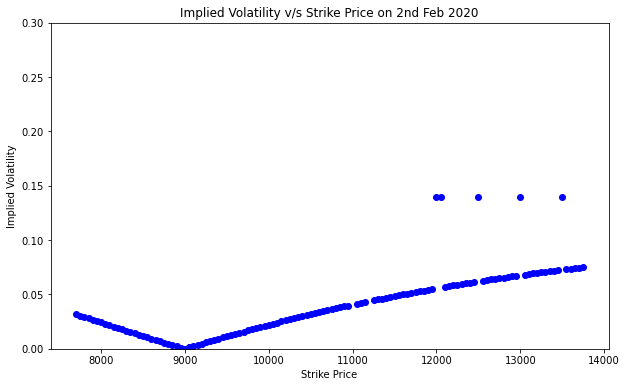

In [36]:
#plot implied volatility v/s strike price on 11th march 2020
df1 = df[df['Date'] == '2020-03-17']
plt.figure(figsize=(10, 6))
plt.plot(df1['StrikePrice'], df1['impliedVolatility'], 'bo')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility v/s Strike Price on 2nd Feb 2020')
#do not plot outliers
plt.ylim(0, 0.3)


plt.show()

In [43]:
#calculate the difference between strike price and underlying value in a new column called diff
df['diff'] = df['StrikePrice'] - df['UnderlyingValue']

#for a given date and option type, get the min absolute difference and store the date, option type and implied volatility for the same in a new dataframe called df2 
df2 = pd.DataFrame(columns=['Date', 'Optiontype', 'impliedVolatility'])
for date in df['Date'].unique():
    for option_type in df['Optiontype'].unique():
        df1 = df[(df['Date'] == date) & (df['Optiontype'] == option_type)]
        df1 = df1[df1['diff'] == df1['diff'].abs().min()]
        df2 = df2.append(df1[['Date', 'Optiontype', 'impliedVolatility']])

df2.head(10)

/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3874845190.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1[['Date', 'Optiontype', 'impliedVolatility']])
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3874845190.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1[['Date', 'Optiontype', 'impliedVolatility']])
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3874845190.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1[['Date', 'Optiontype', 'impliedVolatility']])
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3874845190.py:10: FutureWarning: The frame.append method is deprecated and will 

,Date,Optiontype,impliedVolatility
31,2020-01-24 00:00:00,PE,0.001208
4381,2020-01-24 00:00:00,CE,-0.001209
219,2020-01-29 00:00:00,PE,0.001002
4569,2020-01-29 00:00:00,CE,-0.001003
282,2020-01-30 00:00:00,PE,0.001045
4632,2020-01-30 00:00:00,CE,-0.001045
559,2020-02-04 00:00:00,PE,0.000935
4909,2020-02-04 00:00:00,CE,-0.000936
634,2020-02-05 00:00:00,PE,0.001011
4984,2020-02-05 00:00:00,CE,-0.001012


In [45]:
#ATM Straddle 

#initialize a new dataframe called ATMstraddle 
ATMstraddle = pd.DataFrame(columns=['Date', 'ImpliedVolatility'])
#iterate over the date and for the option type CE and PE calcualte the ImpliedVolatility as average of CE's ImpliedVolatility and PE's Implied Volatility and store it in the ATMstraddle dataframe
for date in df2['Date'].unique():
    df3 = df2[df2['Date'] == date]
    CE = df3[df3['Optiontype'] == 'CE']['impliedVolatility'].values[0]
    PE = df3[df3['Optiontype'] == 'PE']['impliedVolatility'].values[0]
    #calcualte Implied volatility  to 4 decimal places
    
    ATMstraddle = ATMstraddle.append({'Date': date, 'ImpliedVolatility': (CE + PE)/2}, ignore_index=True)

ATMstraddle.head()

/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3574969784.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ATMstraddle = ATMstraddle.append({'Date': date, 'ImpliedVolatility': (CE + PE)/2}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3574969784.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ATMstraddle = ATMstraddle.append({'Date': date, 'ImpliedVolatility': (CE + PE)/2}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3574969784.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ATMstraddle = ATMstraddle.append({'Date': date, 'ImpliedVolatility': (CE + PE)/2}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h

,Date,ImpliedVolatility
0,2020-01-24 00:00:00,-0.0
1,2020-01-29 00:00:00,-0.0
2,2020-01-30 00:00:00,-0.0
3,2020-02-04 00:00:00,-0.0
4,2020-02-05 00:00:00,-0.0


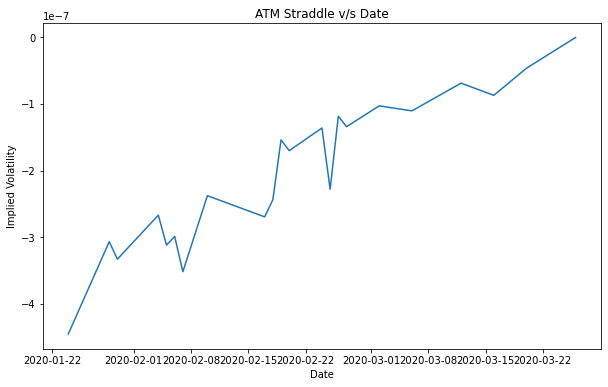

In [48]:
#plot the ATMstraddle v/s date
#make a line plot with date on x-axis and ImpliedVolatility on y-axis
#drop outliers
ATMstraddle = ATMstraddle[ATMstraddle['ImpliedVolatility'] < 0.5]
plt.figure(figsize=(10, 6))
plt.plot(ATMstraddle['Date'], ATMstraddle['ImpliedVolatility'])
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('ATM Straddle v/s Date')
plt.show()


In [49]:
#risk reversal 
#create a dataframe called risk_reversal 
risk_reversal = pd.DataFrame(columns=['Date', 'ImpliedVolatility'])
#iterate over the date and for the option type CE and PE calcualte the ImpliedVolatility as difference of CE's ImpliedVolatility and PE's Implied Volatility and store it in the risk_reversal dataframe
for date in df2['Date'].unique():
    df3 = df2[df2['Date'] == date]
    CE = df3[df3['Optiontype'] == 'CE']['impliedVolatility'].values[0]
    PE = df3[df3['Optiontype'] == 'PE']['impliedVolatility'].values[0]
    #calcualte Implied volatility  to 4 decimal places
    
    risk_reversal = risk_reversal.append({'Date': date, 'ImpliedVolatility': CE - PE}, ignore_index=True)

/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3677572955.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  risk_reversal = risk_reversal.append({'Date': date, 'ImpliedVolatility': CE - PE}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3677572955.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  risk_reversal = risk_reversal.append({'Date': date, 'ImpliedVolatility': CE - PE}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/3677572955.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  risk_reversal = risk_reversal.append({'Date': date, 'ImpliedVolatility': CE - PE}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h

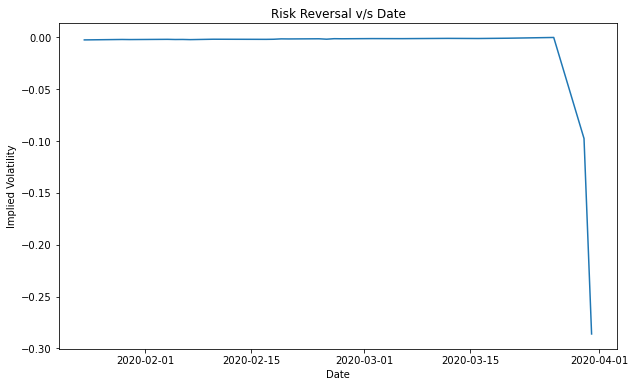

In [50]:
#plot Implied Volatility v/s Date
plt.figure(figsize=(10, 6))
plt.plot(risk_reversal['Date'], risk_reversal['ImpliedVolatility'])
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Risk Reversal v/s Date')
plt.show()

In [51]:
#butterfly spread
#create a dataframe called butterfly_spread
butterfly_spread = pd.DataFrame(columns=['Date', 'ImpliedVolatility'])
#iterate over the date and for the option type CE and PE calcualte the ImpliedVolatility as average of CE's ImpliedVolatility and twice of PE's Implied Volatility and store it in the butterfly_spread dataframe
for date in df2['Date'].unique():
    df3 = df2[df2['Date'] == date]
    CE = df3[df3['Optiontype'] == 'CE']['impliedVolatility'].values[0]
    PE = df3[df3['Optiontype'] == 'PE']['impliedVolatility'].values[0]
    #calcualte Implied volatility  to 4 decimal places
    
    butterfly_spread = butterfly_spread.append({'Date': date, 'ImpliedVolatility': (CE + 2*PE)/3}, ignore_index=True)

/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/4125573086.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  butterfly_spread = butterfly_spread.append({'Date': date, 'ImpliedVolatility': (CE + 2*PE)/3}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/4125573086.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  butterfly_spread = butterfly_spread.append({'Date': date, 'ImpliedVolatility': (CE + 2*PE)/3}, ignore_index=True)
/var/folders/8p/q640lyvd4lg6hp54l3d4dq0h0000gn/T/ipykernel_16533/4125573086.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  butterfly_spread = butterfly_spread.append({'Date': date, 'ImpliedVolatility': (CE + 2*PE)/3}, ignore_index=True)
/var

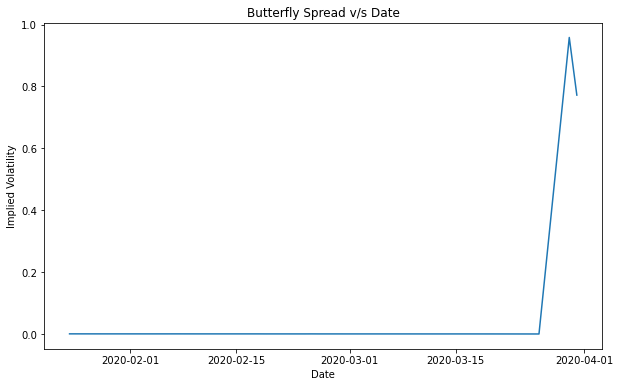

In [52]:
#plot Implied Volatility v/s Date
plt.figure(figsize=(10, 6))
plt.plot(butterfly_spread['Date'], butterfly_spread['ImpliedVolatility'])
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Butterfly Spread v/s Date')
plt.show()


In [59]:
def calculate_implied_probability(implied_volatility, time_to_maturity, option_price, strike_price, current_price):
    # Black-Scholes formula
    d1 = (math.log(current_price / strike_price) + (0.5 * implied_volatility**2) * time_to_maturity) / (implied_volatility * math.sqrt(time_to_maturity))
    d2 = d1 - implied_volatility * math.sqrt(time_to_maturity)

    # Calculate implied probability
    implied_probability = norm.cdf(d2)

    return implied_probability

In [63]:
#iterate over df rows and calculate the implied probability for each row and store it in a new column called impliedProbability
df['impliedProbability'] = 0
for index, row in df.iterrows():
    implied_volatility = row['impliedVolatility']
    time_to_maturity = row['TimeToExpiry']
    option_price = row['LTP']
    strike_price = row['StrikePrice']
    current_price = row['UnderlyingValue']
    implied_probability = calculate_implied_probability(implied_volatility, time_to_maturity, option_price, strike_price, current_price)
    df.at[index, 'impliedProbability'] = implied_probability

df.head()    

,Symbol,Date,Expiry,Optiontype,StrikePrice,Open,High,Low,Close,LTP,...,PremiumTurnoverinLakhs,OpeInt,ChangeinOI,UnderlyingValue,TimeToExpiry,RFR,impliedVolatility,diff,implied_probability,impliedProbability
0,NIFTY,2020-01-24,2020-04-01,PE,10700,-,-,-,1.45,0.0,...,-,-,-,12248.25,0.186301,0.066,0.014540,-1548.25,0.505800,1.0
1,NIFTY,2020-01-24,2020-04-01,PE,10750,-,-,-,1.85,0.0,...,-,-,-,12248.25,0.186301,0.066,0.014086,-1498.25,0.505619,1.0
2,NIFTY,2020-01-24,2020-04-01,PE,10800,-,-,-,2.40,0.0,...,-,-,-,12248.25,0.186301,0.066,0.013633,-1448.25,0.505439,1.0
3,NIFTY,2020-01-24,2020-04-01,PE,10850,-,-,-,3.00,0.0,...,-,-,-,12248.25,0.186301,0.066,0.013182,-1398.25,0.505259,1.0
4,NIFTY,2020-01-24,2020-04-01,PE,10900,-,-,-,3.80,0.0,...,-,-,-,12248.25,0.186301,0.066,0.012733,-1348.25,0.505080,1.0
